# Drive Time Prediction Model
The purpose of the TOS Prediction Model is to estimate the amount of time the driver will stay on site.

## Model Preperation Recepie
The data for the model is spread acros the Tasks, WayPoints, task_inventories and inventory_categories tables in the Replica DB PG database. 

## The steps for creating the model
- We need the area of the delivery

### Inputs:
There are two types of possible inputs:
- One is before the optimization when the team, driver, time, sequence are not know. 
- Second is after the optimzation when we know most of the factors that will effect the TOS.

Note that before the optimization the most important factor of the driving distance is not known. 
Therefore, the results are not roubust especially when there is not enough data

Inputs (partial list):
1. Location as Lat-Long
After the optimization there is also:
4. Team 
5. Driver
6. Hour in the day
7. Location in the sequence

Note that I am using the Inventory Category and not the item it self as there is not enough data points.


In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import geopandas as gpd
import shapely
from geopy.distance import vincenty

In [13]:
#Helper functions
def get_sec_m_h(time_str):
    h, m, s = time_str.split(':')
    h, m, s = int(h), int(m), int(s)
    return (h * 3600 + m * 60 + s, h * 24 + m, h) 

def pandasVincenty(p1, p2):
    '''calculate distance (m) between two lat&long points using the Vincenty formula '''
    return vincenty((p1.x, p1.y), (p2.x, p2.y)).kilometers 

def getInventoryType(invList):
    exclusionList = [ 64.0, 58.0]
    for i in invList:
        if i not in exclusionList:
            return i
    return -1.0

def getMSE(series1, series2):
    return round(sum((t-p) ** 2 for t,p in zip(series1, series2))/len(series2))

In [3]:
csv_results = 'https://prod-eu1-redash.bringg.com/api/queries/408/results.csv?api_key=o0Y0wBXfVrv19WFtJM4XWR6u65RuHopXRnx7qvd8'
df = pd.read_csv(csv_results)

print('Initial Length: ' + str(len(df)))
# Drop incomplete data
df.dropna(subset=['act_in', 'opt_in', 'act_out', 'opt_out'], inplace=True)
print('After dropping nulls: ' + str(len(df)))

Initial Length: 43477
After dropping nulls: 41828


In [4]:
df.columns

Index(['run_id', 'wp_id', 'driver', 'team', 't_date', 'opt_order', 'act_order',
       'opt_in', 'act_in', 'opt_out', 'act_out', 'lat', 'lng'],
      dtype='object')

In [14]:
df['prev_act_out'] = df['act_out'].shift(1)
df['prev_opt_out'] = df['opt_out'].shift(1)

# Drop incomplete data due to the shift
df.dropna(subset=['prev_act_out', 'prev_opt_out'], inplace=True)
print('After dropping nulls: ' + str(len(df)))

df['tbs_opt'] = df.apply(lambda row: (get_sec_m_h(row.opt_in)[0] - get_sec_m_h(row.prev_opt_out)[0])/60, axis=1)
df['tbs_act'] = df.apply(lambda row: (get_sec_m_h(row.act_in)[0] - get_sec_m_h(row.prev_act_out)[0])/60, axis=1)
df['geo'] = [shapely.geometry.Point(xy) for xy in zip(df.lng, df.lat)]
df['prev_loc'] = df['geo'].shift(1)
df['distance'] = df[1:].apply(lambda r: pandasVincenty(r.geo, r.prev_loc), axis=1)

# Show whether the task was executed as planned
df['is_inorder'] = df.opt_order - df.opt_order.shift(1) - 1

After dropping nulls: 41826


In [16]:
temp = df[['run_id', 'driver', 'team', 't_date','act_order', 'opt_order','prev_act_out', 'act_in', 'act_out','prev_opt_out', 'opt_in','opt_out','tbs_act', 'tbs_opt', 'distance', 'is_inorder']]
temp = temp[temp['is_inorder'] == 0]
print(round(temp.describe()))


        run_id   driver     team  act_order  opt_order  tbs_act  tbs_opt  \
count  29547.0  29583.0  29583.0    29583.0    29583.0  29583.0  29583.0   
mean   32405.0   1538.0    101.0        7.0      523.0     19.0      6.0   
std     9627.0    963.0     79.0        3.0    33935.0     24.0     44.0   
min      120.0    371.0     20.0        1.0        2.0   -579.0   -965.0   
25%    29659.0    401.0     21.0        4.0        4.0      9.0      3.0   
50%    34877.0   2153.0    131.0        6.0        6.0     16.0      6.0   
75%    39172.0   2189.0    131.0        9.0        9.0     26.0     10.0   
max    42298.0   4585.0    395.0       35.0  2982604.0    604.0    328.0   

       distance  is_inorder  
count   29583.0     29583.0  
mean        6.0         0.0  
std        49.0         0.0  
min         0.0         0.0  
25%         1.0         0.0  
50%         3.0         0.0  
75%         7.0         0.0  
max      8230.0         0.0  


In [17]:
round(temp[temp.tbs_opt < 0]. head(100))

,run_id,driver,team,t_date,act_order,opt_order,prev_act_out,act_in,act_out,prev_opt_out,opt_in,opt_out,tbs_act,tbs_opt,distance,is_inorder
1261,38505.0,377.0,21,2018-12-06,10,11,11:24:51,11:43:10,11:51:19,13:56:00,12:30:00,16:21:00,18.0,-86.0,2.0,0.0
1262,38505.0,377.0,21,2018-12-06,11,12,11:51:19,11:58:58,12:11:51,16:21:00,13:50:00,16:50:00,8.0,-151.0,1.0,0.0
2184,40489.0,379.0,21,2018-12-14,2,2,07:54:30,08:57:22,08:57:57,23:05:00,07:00:00,23:05:00,63.0,-965.0,1.0,0.0
2185,40489.0,379.0,21,2018-12-14,3,3,08:57:57,09:30:37,09:51:53,23:05:00,07:00:00,23:05:00,33.0,-965.0,10.0,0.0
2186,40489.0,379.0,21,2018-12-14,4,4,09:51:53,10:24:05,10:24:13,23:05:00,07:00:00,23:05:00,32.0,-965.0,8.0,0.0
2187,40489.0,379.0,21,2018-12-14,5,5,10:24:13,11:03:49,11:17:02,23:05:00,07:00:00,23:05:00,40.0,-965.0,11.0,0.0
2188,40489.0,379.0,21,2018-12-14,6,6,11:17:02,12:10:19,12:17:51,23:05:00,07:00:00,07:30:00,53.0,-965.0,12.0,0.0
2621,41069.0,380.0,21,2018-12-14,4,3,07:48:40,07:54:04,08:07:23,23:05:00,07:00:00,23:05:00,5.0,-965.0,1.0,0.0
2671,2485.0,381.0,21,2018-09-20,1,3,08:21:04,06:59:23,06:59:29,07:17:00,07:05:00,07:20:00,-82.0,-12.0,12.0,0.0
3309,38506.0,382.0,21,2018-12-06,11,11,13:02:18,13:43:50,13:49:57,13:03:00,12:50:00,12:24:00,42.0,-13.0,7.0,0.0


In [10]:
t = pd.DataFrame(temp[(temp.run_id == 38505.0)])
round(t.iloc[30:100, :])

,run_id,driver,team,t_date,act_order,opt_order,prev_act_out,act_in,act_out,prev_opt_out,opt_in,opt_out,tbs_act,tbs_opt,distance,is_inorder


In [19]:
# Now we will work only from the second task we dont store the wareohous.
df = pd.DataFrame(df.loc[(df.tbs_act > 1) & (df.tbs_opt > 1) & (df.tbs_act < 60) & (df.tbs_opt < 60)])

print('After dropping TBS that doesnt make sense: ' + str(len(df)))

After dropping TBS that doesnt make sense: 27957


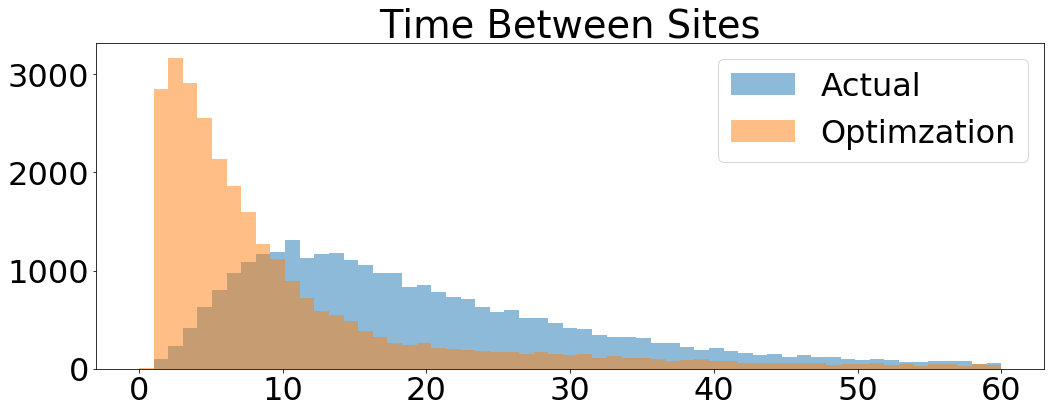

In [23]:
from matplotlib import pyplot
bins = np.linspace(0, 60, 60)
pyplot.hist(df.tbs_act, bins, alpha=0.5, label='Actual')
pyplot.hist(df.tbs_opt, bins, alpha=0.5, label='Optimzation')
pyplot.legend(loc='upper right')
pyplot.title('Time Between Sites')
pyplot.rcParams["figure.figsize"] = (17,16)
pyplot.rcParams.update({'font.size': 32})
pyplot.show()

In [24]:
# Data cleaning 
print('Start: ' + str(len(df)))

#Add hour column
df['h'] = df.apply(lambda row: get_sec_m_h(row.act_in)[2], axis=1)

# Remove the last tasks from request longer then 13 - less then 5% of the data
df.drop(df[df['act_order']>40].index, inplace=True)
print('After removing the last tasks from very long requests: ' + str(len(df)))
# Remove two small teams (3-4 tasks) 
df.drop(df[(df['h']<6) | (df['h']>16)].index, inplace=True)
print('After removing early or late hours: ' + str(len(df)))



Start: 27957
After removing the last tasks from very long requests: 27957
After removing early or late hours: 27700


In [27]:
df.dropna(subset=[ 'lat', 'lng', 'distance', 'h', 'driver', 'team', 'tbs_act'], inplace=True)
print('After removing nulls ' + str(len(df)))

After removing nulls 27698


In [28]:
#Create X and Y tables
Y = df.loc[:,['tbs_act']].values.ravel()
X = df.loc[:,[ 'lat', 'lng', 'distance', 'h', 'driver', 'team', 'tbs_opt']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

lm = linear_model.LinearRegression()
lm_model_after = lm.fit(x_train, y_train)
predictions = lm_model_after.predict(x_test)
print ('LM Score:' + str(round(lm_model_after.score(x_test, y_test), 2)))

rf = RandomForestRegressor(n_estimators = 95, random_state = 42)
rf_model_after = rf.fit(x_train, y_train)
predictions = rf_model_after.predict(x_test)
print ('RF Score:' + str(round(rf_model_after.score(x_test, y_test), 2)))

# After the optimization the Random Forest provides better results
MSE_Model_after = getMSE(y_test, rf_model_after.predict(x_test))

LM Score:0.17
RF Score:0.35


In [29]:
MSE_Bringg = getMSE(y_test, X.tbs_opt)

print('MSE Error of the current opti estimate: ' + str(round(MSE_Bringg)))

print('MSE Error of the model with data AFTER optimization: ' + str(round(MSE_Model_after)) + " = " + 
                                    str(round(100 - 100* MSE_Model_after/ MSE_Bringg)) + r'% Reduction')
#predictions_NN = model.predict(x_test)


MSE Error of the current opti estimate: 71.0
MSE Error of the model with data AFTER optimization: 94.0 = -32.0% Reduction


In [30]:
crs = {'init':'espg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='geo')

df_france = gpd.read_file('france/France_AL8.shp')
df_join = gpd.sjoin(df_france, gdf, how='inner')

df_join.drop(['adminlevel', 'locname','offname','boundary','wikidata','wikimedia','timestamp','note','rpath','ISO3166_2','country','enname'], inplace=True, axis=1)
round(df_join.describe())

,id,index_right,run_id,wp_id,driver,team,opt_order,act_order,lat,lng,tbs_opt,tbs_act,distance,is_inorder,h
count,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0,27692.0
mean,198968.0,21318.0,32382.0,2533804.0,1516.0,100.0,7.0,6.0,48.0,2.0,11.0,20.0,5.0,-68.0,10.0
std,443896.0,12288.0,9679.0,380486.0,957.0,77.0,3.0,3.0,1.0,1.0,11.0,12.0,7.0,11347.0,2.0
min,7444.0,3.0,120.0,1781892.0,371.0,20.0,1.0,2.0,43.0,-5.0,1.0,1.0,0.0,-1888317.0,6.0
25%,49538.0,10506.0,29664.0,2208379.0,400.0,21.0,4.0,4.0,49.0,2.0,4.0,10.0,1.0,0.0,8.0
50%,105146.0,21702.0,34877.0,2647312.0,2152.0,131.0,6.0,6.0,49.0,2.0,7.0,17.0,3.0,0.0,10.0
75%,130632.0,31679.0,39175.0,2878040.0,2185.0,131.0,9.0,9.0,49.0,3.0,12.0,26.0,7.0,0.0,11.0
max,7858565.0,43387.0,42298.0,3086951.0,4544.0,278.0,16.0,30.0,51.0,7.0,60.0,60.0,119.0,12.0,16.0


In [31]:
df_join.head(100)

,id,name,geometry,index_right,run_id,wp_id,driver,team,t_date,opt_order,...,lat,lng,prev_act_out,prev_opt_out,tbs_opt,tbs_act,prev_loc,distance,is_inorder,h
32,357991,Ableiges,"POLYGON ((1.9512079 49.0859074, 1.9540624 49.0...",7440,27677.0,2692821,392.0,21,2018-11-28,4,...,49.069515,1.964914,09:42:47,08:41:00,4.000000,5.800000,POINT (1.9264756 49.080681),4.428167,0.0,9
32,357991,Ableiges,"POLYGON ((1.9512079 49.0859074, 1.9540624 49.0...",5584,18658.0,2222156,388.0,21,2018-10-24,11,...,49.069786,1.965166,10:43:29,11:25:00,13.000000,15.166667,POINT (1.9781838 49.1490646),8.936702,0.0,10
32,357991,Ableiges,"POLYGON ((1.9512079 49.0859074, 1.9540624 49.0...",4273,3475.0,1826671,385.0,21,2018-09-24,6,...,49.089309,1.981209,08:52:53,08:50:00,15.000000,19.550000,POINT (1.845035 49.049193),15.705065,0.0,9
32,357991,Ableiges,"POLYGON ((1.9512079 49.0859074, 1.9540624 49.0...",7996,39179.0,2878391,393.0,21,2018-12-08,8,...,49.089765,1.979937,11:22:12,10:35:51,32.650000,55.066667,POINT (1.686072 49.125162),32.731994,0.0,12
32,357991,Ableiges,"POLYGON ((1.9512079 49.0859074, 1.9540624 49.0...",5498,18658.0,1813564,388.0,21,2018-09-22,9,...,49.089772,1.980204,09:06:41,10:20:00,19.000000,43.383333,POINT (2.22511 48.9944807),29.081511,0.0,9
33,401606,Ablis,"POLYGON ((1.8113114 48.5161457, 1.8117138 48.5...",24128,30261.0,2146106,2159.0,131,2018-10-18,3,...,48.513386,1.836970,08:05:33,07:02:00,17.000000,49.466667,POINT (2.0097551 48.5248615),19.148444,0.0,8
33,401606,Ablis,"POLYGON ((1.8113114 48.5161457, 1.8117138 48.5...",26871,32264.0,2382186,2167.0,131,2018-11-06,4,...,48.515688,1.833556,09:16:26,08:53:00,25.000000,34.400000,POINT (1.9555511 48.74788820000001),29.144212,0.0,9
33,401606,Ablis,"POLYGON ((1.8113114 48.5161457, 1.8117138 48.5...",21442,31281.0,2311257,2152.0,131,2018-10-31,5,...,48.519398,1.835028,09:41:53,09:17:00,14.000000,23.033333,POINT (1.8233379 48.6442407),13.950440,0.0,10
33,401606,Ablis,"POLYGON ((1.8113114 48.5161457, 1.8117138 48.5...",31116,29748.0,2061798,2182.0,131,2018-10-12,7,...,48.520358,1.837022,09:49:10,10:27:00,14.000000,13.416667,POINT (1.9735428 48.5313933),15.145762,0.0,10
35,104729,Ablon-sur-Seine,"POLYGON ((2.4107566 48.7219892, 2.41091 48.722...",19376,39754.0,2878882,2146.0,131,2018-12-08,3,...,48.720644,2.416143,07:31:42,07:49:00,2.000000,5.950000,POINT (2.4353154 48.7258443),2.197510,0.0,7


In [ ]:
df.dropna(subset=[ 'lat', 'lng', 'd_tbs_act', 'id'], inplace=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#create model
model = Sequential()
n_cols = x_train.shape[1]

#add model layers
model.add(Dense(200, activation='relu', input_shape=(n_cols,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))

#compile model using mse as a measure of model performance
model.compile(optimizer='adam', loss='mean_squared_error')
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)
#train model
model.fit(x_train, y_train, validation_split=0.2, epochs=30, callbacks=[early_stopping_monitor])

OSError: no such file or directory: 'cb_2015_us_cd114_20m.zip'